# Treinamento dos modelos de inteligência artificial
Modelos a serem treinados:
- CNN
- DAE
- Conv DAE


## Importação das bibliotecas necessárias

In [ ]:
import scipy.io
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from keras.utils import plot_model

sns.set_theme()

from sklearn.metrics import accuracy_score, precision_score, roc_curve, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from sklearn import metrics

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()


## Importando o banco de dados dos arquivos gerados pelo MATLAB

In [ ]:
# EDIT AREA
file_name = 'dataset_9.mat'
measurement_size = 256
n_of_devices = 4
n_of_measurements = 1000

#--------- END OF EDIT AREA -----------------


n = n_of_devices * n_of_measurements

size_reshaped = int(np.sqrt(measurement_size))

mat_data = scipy.io.loadmat(file_name)
measurements = mat_data['meas']
data_flatten = measurements.reshape([n, measurement_size])
data_images = data_flatten.reshape([n, size_reshaped, size_reshaped])
labels = np.repeat(np.arange(0,n_of_devices), n_of_measurements)

- Agora, plotando as medições para verificar a semelhança entre elas

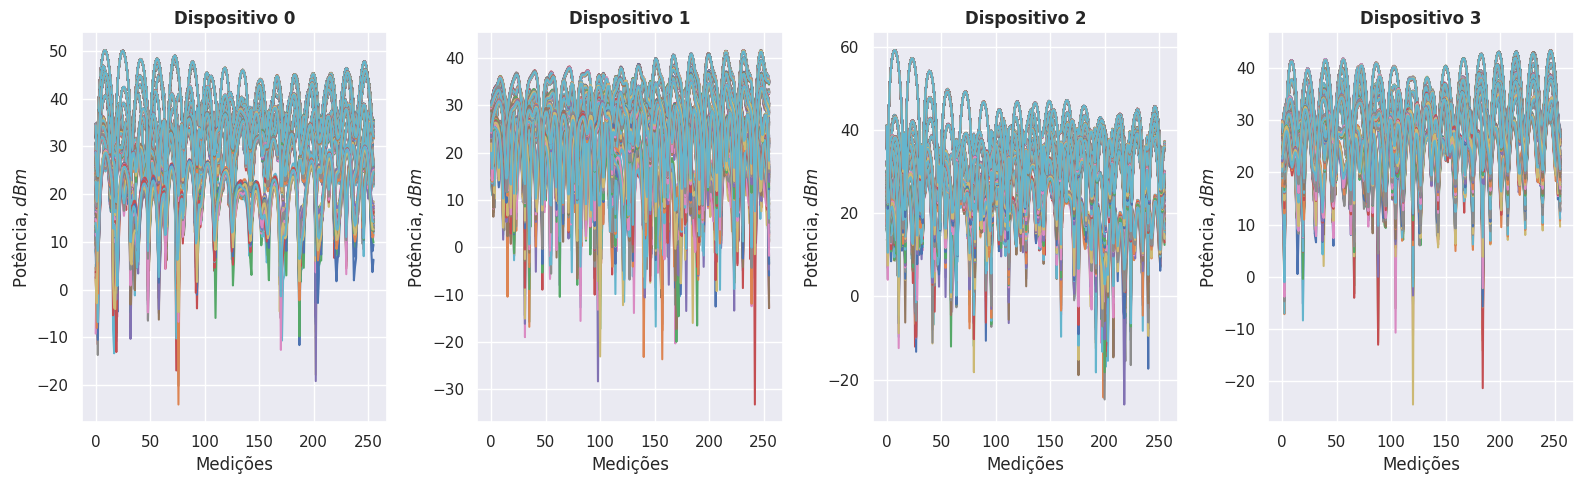

In [ ]:
# EDIT AREA

n_of_plots = 1000
max_plots_per_row = 5

# ------- END OF EDIT AREA ------
plots_per_row = min(max_plots_per_row, n_of_devices)

n_of_subplots_rows = (n_of_devices // max_plots_per_row) + 1
samples = np.arange(measurement_size)

fig, ax = plt.subplots(n_of_subplots_rows, plots_per_row, figsize=(4*plots_per_row,5*n_of_subplots_rows))

for i in range(n_of_devices):
    ax[i].set_title(f'Dispositivo {i}', fontweight='bold')
    ax[i].set_ylabel('Potência, $dBm$')
    ax[i].set_xlabel('Medições')
    for k in range(n_of_plots):
        ax[i].plot(samples, data_flatten[i*n_of_measurements + k])

plt.tight_layout()

### Função auxiliar para plotar medições em 3D

In [ ]:
def make_3d_matrix(N):
  # Define the limits
  x_min, x_max = -15, 15
  y_min, y_max = -15, 15

  # Create the NxN matrix with coordinates
  matrix = []
  x_step = (x_max - x_min) / (N - 1)
  y_step = (y_max - y_min) / (N - 1)

  for i in range(N):
      row = []
      for j in range(N):
          x = x_min + j * x_step
          y = y_max - i * y_step
          row.append((x, y))
      matrix.append(row)
  return np.array(matrix)

### Plot dos gráficos em 3D para visualização melhor do padrão#

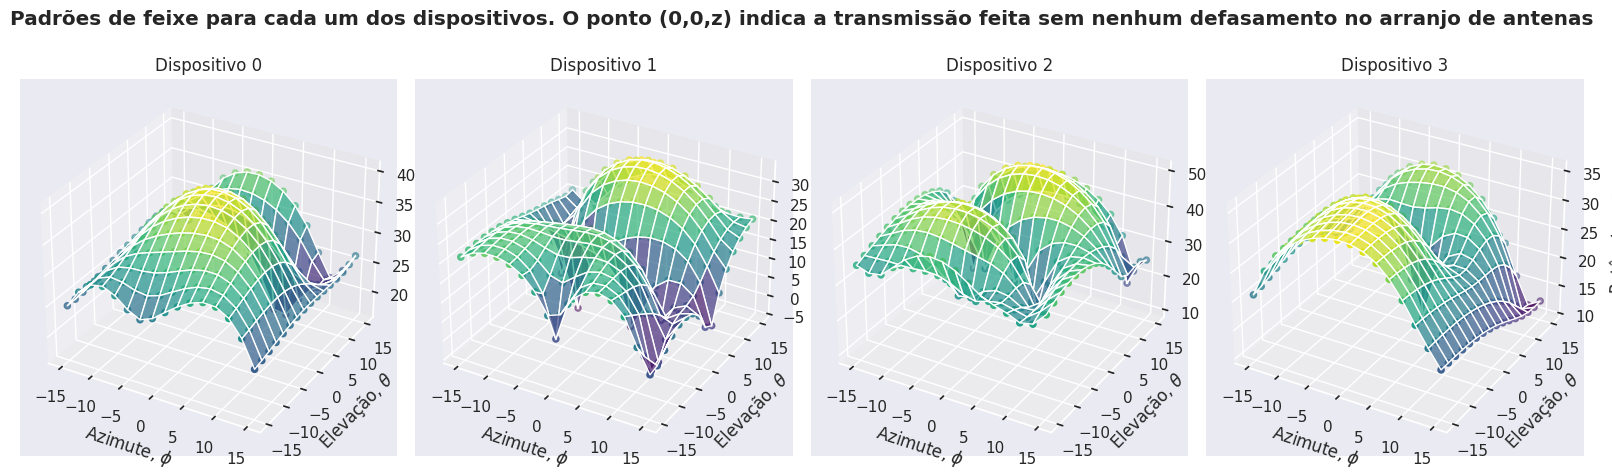

In [ ]:
# DO NOT EDIT!!!!

matrix = make_3d_matrix(data_images.shape[1])
# Extract x and y coordinates from the matrix
x = matrix[:, :, 0]
y = matrix[:, :, 1]
# Generate random z values (you can replace this with your own data)


indexs = np.zeros([n_of_devices])

for i, index in enumerate(indexs):
  id = np.random.randint(0, n_of_measurements)
  indexs[i] = id


fig, axs = plt.subplots(n_of_subplots_rows, plots_per_row, figsize=(4*plots_per_row,5*n_of_subplots_rows), subplot_kw=dict(projection="3d"))

fig.suptitle(f'Padrões de feixe para cada um dos dispositivos. O ponto (0,0,z) indica a transmissão feita sem nenhum defasamento no arranjo de antenas', fontweight='bold')
for i, ax in enumerate(axs):
  data = data_images[int(indexs[i] + i*1000)]
  ax.scatter(x, y, data, c=data, cmap='viridis')
  ax.plot_surface(x, y, data, cmap='viridis', alpha=0.7)

  # Set labels for the axes
  ax.set_title(f'Dispositivo {i}')
  ax.set_xlabel('Azimute, $\phi$')
  ax.set_ylabel('Elevação, $\\theta$')
  ax.set_zlabel('Potência, $dBm$')

# Show the plot
plt.tight_layout()


### Manipulação do banco de dados pré-treinamento

- Separação de treino e teste

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(
    data_images, labels, test_size=0.2, random_state=21
)

train_data_flatten = train_data.reshape([train_data.shape[0], 256])
test_data_flatten = test_data.reshape([test_data.shape[0], 256])
train_labels_flatten = train_labels
test_labels_flatten = test_labels


- Normalização dos valores para um melhor treinamento

In [ ]:
# DON'T EDIT

min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)
train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

train_data_flatten = (train_data_flatten - min_val) / (max_val - min_val)
test_data_flatten = (test_data_flatten - min_val) / (max_val - min_val)
train_data_flatten = tf.cast(train_data_flatten, tf.float32)
test_data_flatten = tf.cast(test_data_flatten, tf.float32)


- Conversão dos rótulos. Dispositivos autenticados serão *True* enquanto os invasores serão *False*. Os dois primeiros dispositivos serão considerados como autenticados, e os dois últimos como invasore

In [ ]:
# EDIT AREA

train_labels = (train_labels <= 1)
test_labels = (test_labels <= 1)

train_labels_flatten = (train_labels_flatten <= 1)
test_labels_flatten = (test_labels_flatten <= 1)


# ----- END OF EDIT AREA -----------
normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

normal_train_data_flatten = train_data_flatten[train_labels_flatten]
normal_test_data_flatten = test_data_flatten[test_labels_flatten]

anomalous_train_data_flatten = train_data_flatten[~train_labels_flatten]
anomalous_test_data_flatten = test_data_flatten[~test_labels_flatten]

## Treinamento de rede neural convolucional (CNN)

In [ ]:
convModel = tf.keras.Sequential()
convModel.add(layers.Conv2D(32, (1, 1), activation='relu', input_shape=(16, 16, 1)))
convModel.add(layers.MaxPooling2D((2, 2)))
convModel.add(layers.Conv2D(64, (3, 3), activation='relu'))
convModel.add(layers.MaxPooling2D((2, 2)))
convModel.add(layers.Conv2D(64, (3, 3), activation='relu'))
convModel.add(layers.Flatten())
convModel.add(layers.Dense(8, activation='relu'))
convModel.add(layers.Dense(2, activation='sigmoid'))

convModel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

ConvHistory = convModel.fit(train_data, train_labels, epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


100/100 [==============================] - 2s 13ms/step - loss: 0.6934 - accuracy: 0.5094
Epoch 2/10
100/100 [==============================] - 2s 15ms/step - loss: 0.6932 - accuracy: 0.5044
Epoch 3/10
100/100 [==============================] - 2s 17ms/step - loss: 0.6931 - accuracy: 0.5044
Epoch 4/10
100/100 [==============================] - 2s 17ms/step - loss: 0.6921 - accuracy: 0.5066
Epoch 5/10
100/100 [==============================] - 1s 13ms/step - loss: 0.6769 - accuracy: 0.5972
Epoch 6/10
100/100 [==============================] - 1s 11ms/step - loss: 0.4415 - accuracy: 0.8022
Epoch 7/10
100/100 [==============================] - 1s 12ms/step - loss: 0.2282 - accuracy: 0.9094
Epoch 8/10
100/100 [==============================] - 1s 10ms/step - loss: 0.1199 - accuracy: 0.9678
Epoch 9/10
100/100 [==============================] - 1s 11ms/step - loss: 0.0539 - accuracy: 0.9969
Epoch 10/10
100/100 [==============================] - 1s 10ms/step - loss: 0.0284 - accuracy: 0.9994


## Treinamento de um Deep autoencoder convolutional

In [ ]:
n_epochs = 50

In [ ]:
class ConvDAE(Model):
  def __init__(self):
    super(ConvDAE, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(16, 16, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

ConvAutoencoder = ConvDAE()

ConvAutoencoder.compile(optimizer='adam', loss='mse')

ConvDaeHistory = ConvAutoencoder.fit(normal_train_data, normal_train_data,
          epochs=n_epochs,
          validation_data=(test_data, test_data),
          shuffle=True)


Epoch 1/50
50/50 [==============================] - 3s 23ms/step - loss: 0.0184 - val_loss: 0.0066
Epoch 2/50
50/50 [==============================] - 1s 16ms/step - loss: 0.0066 - val_loss: 0.0055
Epoch 3/50
50/50 [==============================] - 1s 24ms/step - loss: 0.0059 - val_loss: 0.0052
Epoch 4/50
50/50 [==============================] - 1s 30ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 5/50
50/50 [==============================] - 1s 29ms/step - loss: 0.0050 - val_loss: 0.0044
Epoch 6/50
50/50 [==============================] - 1s 23ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 7/50
50/50 [==============================] - 1s 15ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 8/50
50/50 [==============================] - 1s 17ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 9/50
50/50 [==============================] - 1s 18ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 10/50
50/50 [==============================] - 1s 17ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 11/

## Treinamento de um DAE

In [ ]:
class DAE(Model):
  def __init__(self):
    super(DAE, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(256, activation="relu"),
      layers.Dense(128, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(128, activation="relu"),
      layers.Dense(256, activation='tanh')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

dae = DAE()

dae.compile(optimizer='adam', loss='mse')
DaeHistory = dae.fit(normal_train_data_flatten, normal_train_data_flatten,
          epochs=n_epochs,
          validation_data=(test_data_flatten, test_data_flatten),
          shuffle=True)

Epoch 1/50
50/50 [==============================] - 2s 11ms/step - loss: 0.1032 - val_loss: 0.0041
Epoch 2/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 3/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 4/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 5/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 6/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 7/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 8/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 9/50
50/50 [==============================] - 1s 10ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 10/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 11/

## Comparação entre o DAE e o ConvDAE

- Comparação do erro médio quadrático

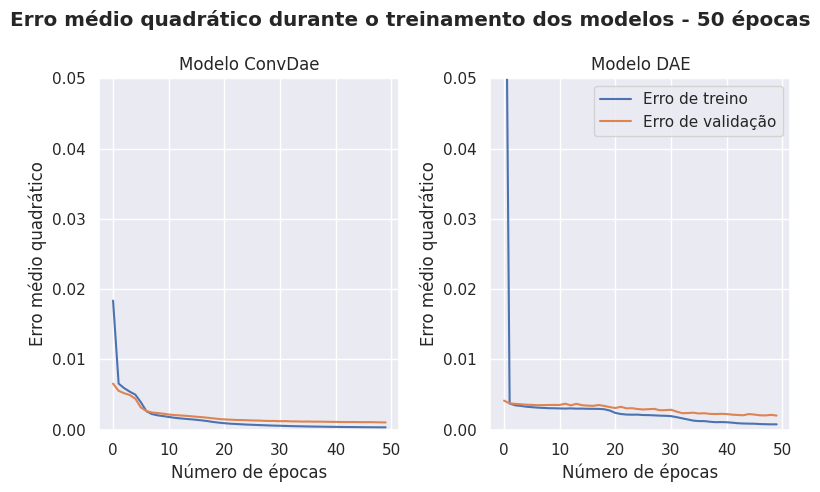

In [ ]:
DaeHistories = [ConvDaeHistory, DaeHistory]
model_name = ['ConvDae', 'DAE']
fig, axs = plt.subplots(1, 2, figsize=(8,5))

fig.suptitle(f'Erro médio quadrático durante o treinamento dos modelos - {n_epochs} épocas', fontweight='bold')

for i, ax in enumerate(axs):
  ax.set_title(f'Modelo {model_name[i]}')
  ax.plot(DaeHistories[i].history["loss"], label="Training Loss")
  ax.plot(DaeHistories[i].history["val_loss"], label="Validation Loss")
  ax.set_ylim(0, 0.05)
  ax.set_xlabel(f'Número de épocas')
  ax.set_ylabel(f'Erro médio quadrático')
  ax.grid('on')

plt.legend(['Erro de treino', 'Erro de validação'])
plt.tight_layout()


- Comparação da reconstrução dos dados para dispositivo autenticado

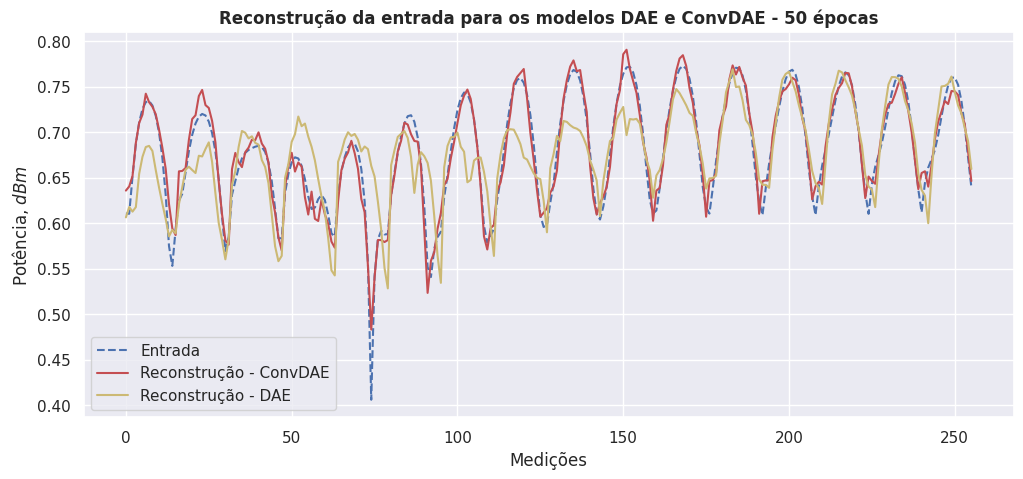

In [ ]:
# Edit area
index = 100

# ---- END OF EDIT AREA ------


encoded_data = ConvAutoencoder.encoder(normal_test_data).numpy()
decoded_data = ConvAutoencoder.decoder(encoded_data).numpy()

encoded_data_flatten = dae.encoder(normal_test_data_flatten).numpy()
decoded_data_flatten = dae.decoder(encoded_data_flatten).numpy()

plt.figure(figsize=(12,5))

plt.plot(normal_test_data[index].flatten(), 'b--')
plt.plot(decoded_data[index].flatten(), 'r')
plt.plot(decoded_data_flatten[index], 'y')

plt.title(f'Reconstrução da entrada para os modelos DAE e ConvDAE - {n_epochs} épocas', fontweight='bold')
plt.xlabel(f'Medições')
plt.ylabel(f'Potência, $dBm$')
plt.legend(labels=["Entrada", "Reconstrução - ConvDAE", "Reconstrução - DAE"])

plt.show()

- Comparação da reconstrução para dispositivos invasores

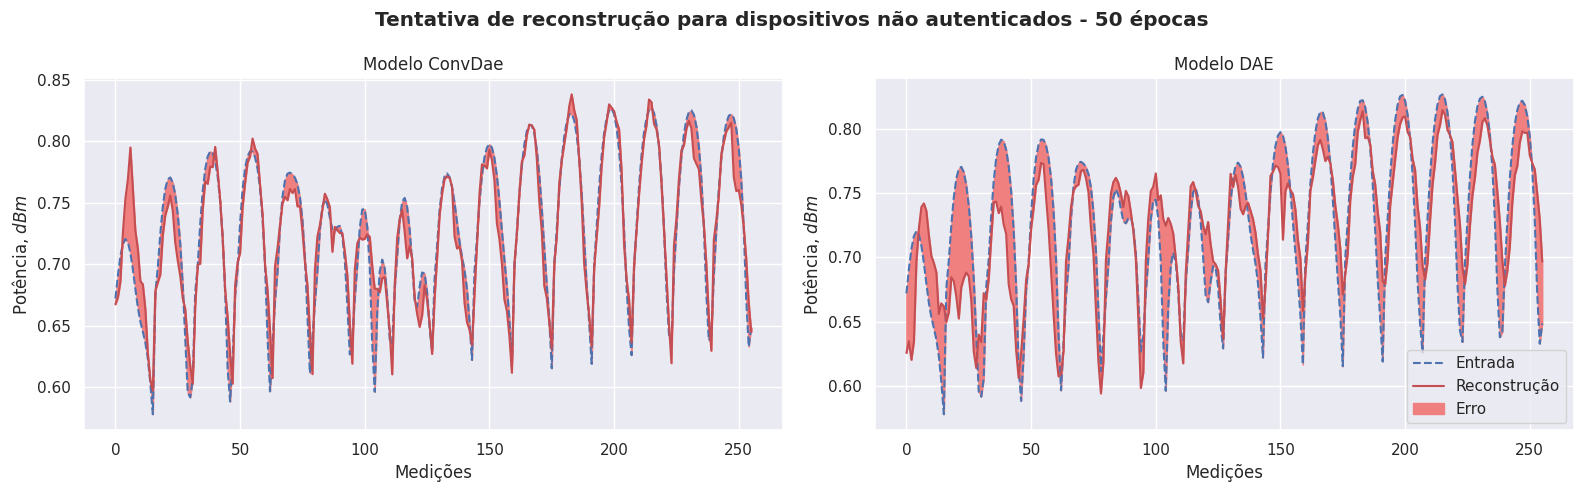

In [ ]:
# Edit area
index = 100

# ---- END OF EDIT AREA ------


encoded_data = ConvAutoencoder.encoder(anomalous_test_data).numpy()
decoded_data = ConvAutoencoder.decoder(encoded_data).numpy()

encoded_data_flatten = dae.encoder(anomalous_test_data_flatten).numpy()
decoded_data_flatten = dae.decoder(encoded_data_flatten).numpy()

datas = [decoded_data[index].flatten(), decoded_data_flatten[index]]

fig, axs = plt.subplots(1,2, figsize=(16, 5))
fig.suptitle(f'Tentativa de reconstrução para dispositivos não autenticados - {n_epochs} épocas', fontweight='bold')

for i, ax in enumerate(axs):
  ax.plot(anomalous_test_data[index].flatten(), 'b--')
  ax.set_title(f'Modelo {model_name[i]}')
  ax.plot(datas[i], 'r')
  ax.fill_between(np.arange(256), datas[i], anomalous_test_data[index].flatten(), color='lightcoral')

  ax.set_xlabel('Medições')
  ax.set_ylabel(f'Potência, $dBm$')


plt.legend(labels=["Entrada", "Reconstrução", "Erro"])
plt.tight_layout()

- Comparação de Thresholds

50/50 [==============================] - 0s 2ms/step
ConvDAE Threshold: 0.014402810484170914
DAE Threshold: 0.025363121181726456


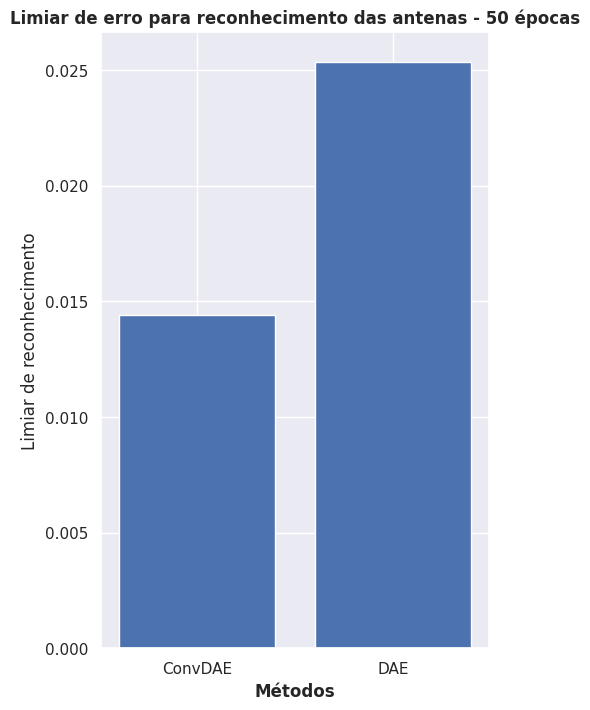

In [ ]:
ConvReconstructions = ConvAutoencoder.predict(normal_train_data)
ConvRecons = ConvReconstructions.reshape([ConvReconstructions.shape[0],256])

reconstructions = dae.predict(normal_train_data_flatten)


conv_train_loss = tf.keras.losses.mae(ConvRecons, normal_train_data.reshape([normal_train_data.shape[0], 256]))
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data_flatten)

conv_threshold = np.mean(conv_train_loss) + np.std(conv_train_loss)
threshold = np.mean(train_loss) + np.std(train_loss)

print(f'ConvDAE Threshold: {conv_threshold.numpy()}\nDAE Threshold: {threshold.numpy()}')

# Data for the bars
methods = ["ConvDAE", "DAE"]
thresholds = [conv_threshold, threshold]  # Replace with your actual data

# Set Y and X axis labels
plt.figure(figsize=(5,8))
plt.title(f'Limiar de erro para reconhecimento das antenas - {n_epochs} épocas', fontweight='bold')
plt.ylabel("Limiar de reconhecimento")
plt.xlabel("Métodos", fontweight='bold')

# Create the bar graph
plt.bar(methods, thresholds)

# Display the plot
plt.show()



- Comparação de Acurácia, Precisão e Recall

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  recons = reconstructions.reshape([reconstructions.shape[0],256])
  loss = tf.keras.losses.mae(recons, data.reshape([data.shape[0], 256]))
  return tf.math.less(loss, threshold)

def return_metrics(predictions, labels):
  true_positives = sum(a and p for a, p in zip(labels, predictions))
  true_negatives = sum((not a) and (not p) for a, p in zip(labels, predictions))
  false_positives = sum(not a and p for a, p in zip(labels, predictions))
  false_negatives = sum(a and not p for a, p in zip(labels, predictions))

  specifity = true_negatives / (true_negatives + false_positives)

  return [accuracy_score(labels, predictions), precision_score(labels, predictions), recall_score(labels, predictions), specifity]

25/25 [==============================] - 0s 7ms/step
414 385 1 0
[0.99875    0.99759036 1.         0.99740933]


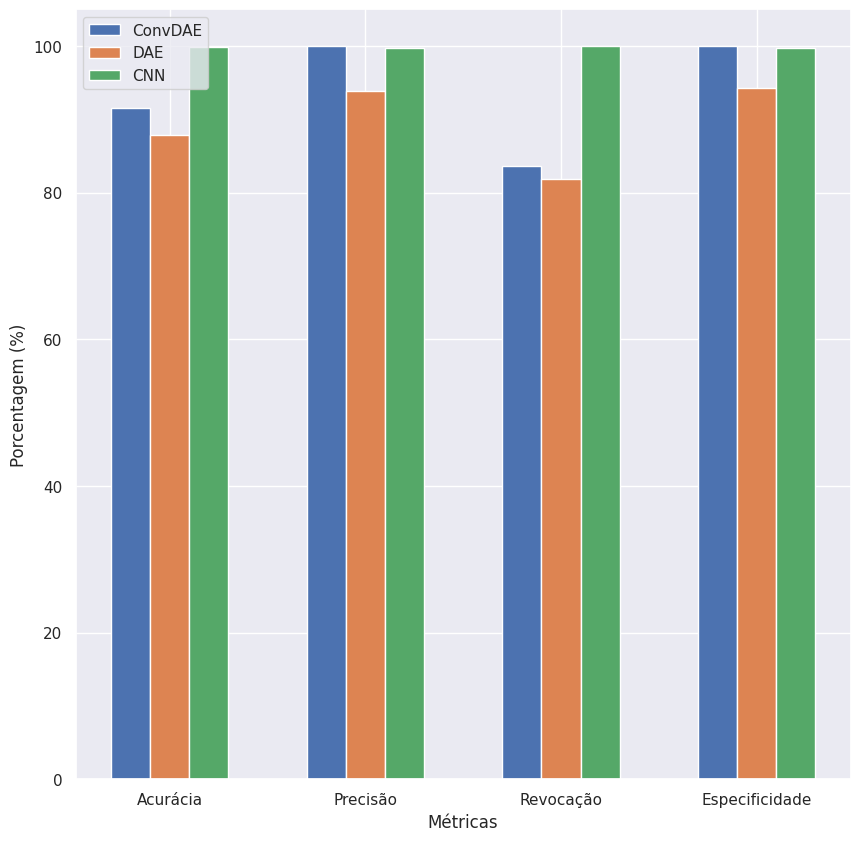

In [ ]:
convPreds = predict(ConvAutoencoder, test_data, conv_threshold)
daePreds = predict(dae, test_data_flatten, threshold)

convMetrics = np.array(return_metrics(convPreds, test_labels))
daeMetrics = np.array(return_metrics(daePreds, test_labels_flatten))
# CONVOLUTIONAL
preds = convModel.predict(test_data)
preds_bool = [bool(np.argmax(i)) for i in preds]

labels = test_labels.tolist()

true_positives = sum(a and p for a, p in zip(labels, preds_bool))
true_negatives = sum((not a) and (not p) for a, p in zip(labels, preds_bool))
false_positives = sum(not a and p for a, p in zip(labels, preds_bool))
false_negatives = sum(a and not p for a, p in zip(labels, preds_bool))
print(true_positives, true_negatives, false_positives, false_negatives)
# Calculate accuracy, precision, and recall
accuracy = (true_positives + true_negatives) / len(labels)
precision = true_positives / ((true_positives + false_positives) or 1)
recall = true_positives / (true_positives + false_negatives)
specifity = true_negatives / (true_negatives + false_positives)

cnnMetrics = np.array([accuracy, precision, recall, specifity])

print(cnnMetrics)

# Sample data for the three pairs of bars
categories = ['Acurácia', 'Precisão', 'Revocação', 'Especificidade']

# Set the bar width
bar_width = 0.2

# Create an array of positions for the bars
x = range(len(categories))

plt.figure(figsize=(10,10))

# Create the bar plots for each category
plt.bar(x, convMetrics*100, width=bar_width)
plt.bar([i + bar_width for i in x], daeMetrics*100, width=bar_width)
plt.bar([i + 2*bar_width for i in x], cnnMetrics*100, width=bar_width)


# Set the X-axis labels
plt.xticks([i + bar_width for i in x], categories)
# plt.title("Comparação das métricas dos modelos")
plt.xlabel("Métricas")
# Set Y-axis label
plt.ylabel('Porcentagem (%)')

# Add a legend
plt.legend(["ConvDAE", "DAE", "CNN"])

# Show the plot
plt.show()

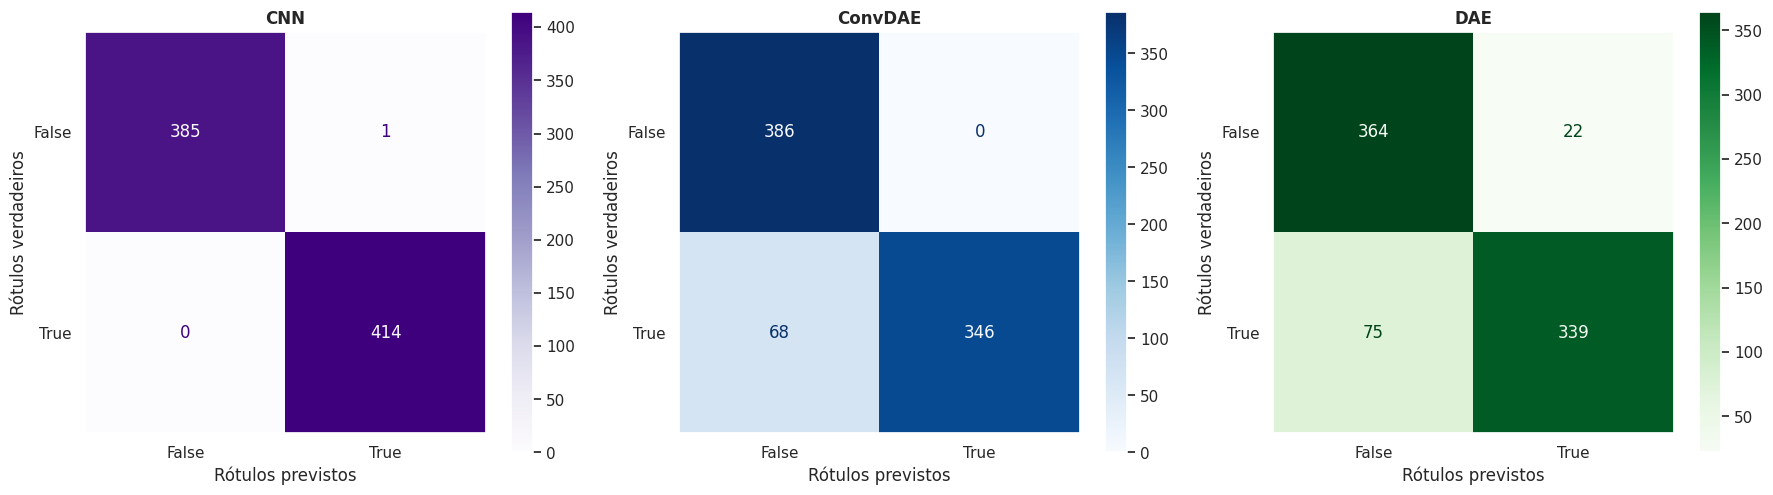

In [ ]:
l = test_labels
l_f = test_labels_flatten

confusion_matrix_cnn = metrics.confusion_matrix(l, preds_bool)
confusion_matrix_convDAE = metrics.confusion_matrix(l, convPreds)
confusion_matrix_DAE = metrics.confusion_matrix(l_f, daePreds)


cms = [confusion_matrix_cnn, confusion_matrix_convDAE, confusion_matrix_DAE]
cmaps = ['Purples', 'Blues', 'Greens']
models = ['CNN', 'ConvDAE', 'DAE']

fig, axs = plt.subplots(1,3, figsize=(18, 5))
# fig.suptitle("Matriz de confusão para os três modelos treinados", fontweight='bold')

for i, ax in enumerate(axs):
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cms[i], display_labels = [False, True])
  cm_display.plot(cmap=cmaps[i], ax=ax)
  ax.grid(False)
  ax.set_title(f'{models[i]}', fontweight='bold')
  ax.set_xlabel('Rótulos previstos')
  ax.set_ylabel('Rótulos verdadeiros')

plt.tight_layout()